# Hacking on fitting models in 3D

PyAstro 2018

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%mpdaf

import matplotlib.pyplot as plt

from astropy.modeling import models, fitting
from muse_analysis.plotutils import show_images_grid

import warnings
warnings.simplefilter('ignore', UserWarning)

Numpy 1.14.3
Astropy 3.1.dev21816
MPDAF 3.0.dev2675


/home/simon/.pyenv/versions/3.6.3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Using a small cube with a star in the middle. This cube is already rebinned, but I rebin again to have fewer slices and fit faster (this is really for the experiment).

In [116]:
c = Cube('star_rebin.fits')
print(c)
c = c.rebin((5, 1, 1))
c

<Cube(shape=(87, 50, 50), unit='', dtype='None')>


<Cube(shape=(17, 50, 50), unit='', dtype='float64')>

Have a quicklook at the white-light image, and the star profile.

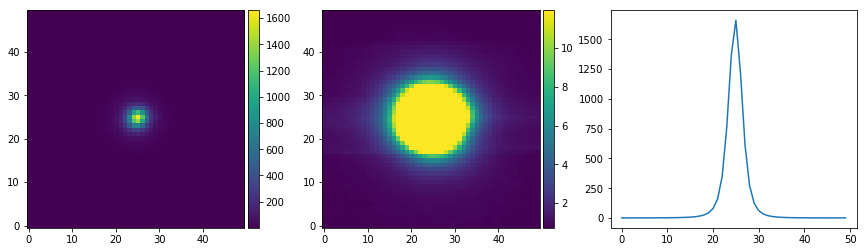

In [117]:
im = c.mean(axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
im.plot(ax=ax1, colorbar='v')
im.plot(ax=ax2, colorbar='v', zscale=True)
ax3.plot(im.data[im.shape[0]//2]);

## Fit just one image

In [6]:
yy, xx = np.mgrid[:im.shape[0], :im.shape[1]]
x_0, y_0 = np.array(im.shape) / 2

data = im.data.filled(0)

model = models.Const2D(amplitude=0) + models.Moffat2D(amplitude=data.max(), x_0=x_0, y_0=y_0, gamma=3, alpha=2.5)
model

<CompoundModel0(amplitude_0=0., amplitude_1=1659.26047148, x_0_1=25., y_0_1=25., gamma_1=3., alpha_1=2.5)>

In [7]:
fitter = fitting.LevMarLSQFitter()
fit = fitter(model, xx, yy, data, maxiter=500)
fit

<CompoundModel0(amplitude_0=0.97230683, amplitude_1=1701.52724239, x_0_1=24.83433759, y_0_1=24.7628894, gamma_1=2.76389006, alpha_1=2.26009349)>

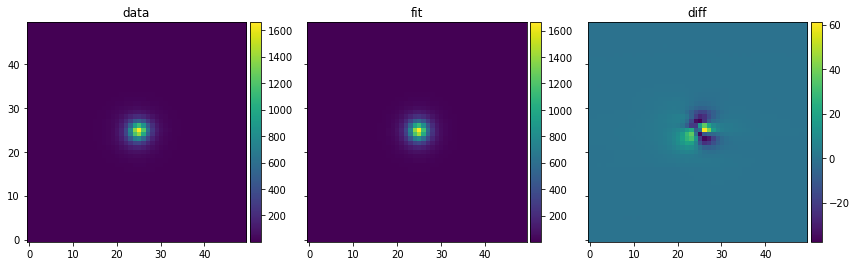

In [8]:
show_images_grid([data, fit(xx, yy), data - fit(xx, yy)], figsize=(4, 4), titles=('data', 'fit', 'diff'));

## Fit all slices

In [9]:
shape = c.shape[1:]
yy, xx = np.mgrid[:shape[0], :shape[1]]
x_0, y_0 = np.array(shape) / 2

fitter = fitting.LevMarLSQFitter()

In [10]:
fitres = []
for im in c:
    data = im.data.filled(0)
    model = models.Const2D(amplitude=0) + models.Moffat2D(amplitude=data.max(), x_0=x_0, y_0=y_0, gamma=3, alpha=2.5)
    #model = models.Moffat2D(amplitude=data.max(), x_0=x_0, y_0=y_0, gamma=3, alpha=2.5)
    fit = fitter(model, xx, yy, data, maxiter=500)
    fitres.append(fit)

In [11]:
fitres

[<CompoundModel1(amplitude_0=0.93096377, amplitude_1=1753.54048669, x_0_1=24.86784414, y_0_1=24.69442081, gamma_1=3.37249207, alpha_1=2.44346401)>,
 <CompoundModel2(amplitude_0=0.94088614, amplitude_1=2381.21067331, x_0_1=24.8605224, y_0_1=24.71052276, gamma_1=3.14197958, alpha_1=2.34593096)>,
 <CompoundModel3(amplitude_0=0.99910091, amplitude_1=2405.97682473, x_0_1=24.85101529, y_0_1=24.72605836, gamma_1=3.00064027, alpha_1=2.29750943)>,
 <CompoundModel4(amplitude_0=0.9985743, amplitude_1=2296.42235581, x_0_1=24.83033584, y_0_1=24.73900801, gamma_1=2.9577778, alpha_1=2.31246834)>,
 <CompoundModel5(amplitude_0=1.05923325, amplitude_1=2276.12150493, x_0_1=24.82712772, y_0_1=24.75604221, gamma_1=2.87166054, alpha_1=2.3065077)>,
 <CompoundModel6(amplitude_0=1.19331164, amplitude_1=2237.22968792, x_0_1=24.83295207, y_0_1=24.76532322, gamma_1=2.83668768, alpha_1=2.31649026)>,
 <CompoundModel7(amplitude_0=1.1491433, amplitude_1=1960.35679928, x_0_1=24.84135268, y_0_1=24.7717288, gamma_1=2.77

## Fit all slices - with Nadia's branch

In [12]:
n_models = c.shape[0]

shape = c.shape[1:]
yy, xx = np.mgrid[:shape[0], :shape[1]]
x_0, y_0 = np.array(shape) / 2

fitter = fitting.LevMarLSQFitter()

In [13]:
data = c.data.filled(0)
amplitude = [d.max() for d in data]

In [14]:
data.shape

(17, 50, 50)

In [15]:
x_0, y_0

(25.0, 25.0)

In [16]:
#model = (models.Const2D(amplitude=[0]*n_models, n_models=n_models) + 
#         models.Moffat2D(amplitude=amplitude, x_0=[x_0]*n_models, y_0=[y_0]*n_models, gamma=[3]*n_models, alpha=[2.5]*n_models, n_models=n_models))

model = models.Moffat2D(amplitude=amplitude, 
                        x_0=[x_0]*n_models, 
                        y_0=[y_0]*n_models, 
                        gamma=[3]*n_models, 
                        alpha=[2.5]*n_models, 
                        n_models=n_models)

fit = fitter(model, xx, yy, data, maxiter=500, estimate_jacobian=True)

/home/simon/dev/astropy/astropy/modeling/functional_models.py:2340: RuntimeWarning: overflow encountered in multiply
  return amplitude * (1 + rr_gg) ** (-alpha)


In [17]:
fit

<Moffat2D(amplitude=[3717.79241318, 1671.36913366, 2414.52069863, 1224.94367863, 3091.7904829 , 1732.25959284, 1291.0823918 , 1185.27552187, 2267.95675725, 1085.53751763, 675.25733686,  203.25266295,  565.3968797 ,  378.82329221,  467.61150088, 275.2585092 ,  187.70317083], x_0=[24.83343602, 24.83870348, 24.82822186, 24.8101219 , 24.79718616, 24.7982329 , 24.8009886 , 24.80804346, 24.80557622, 24.79588313, 24.78119714, 24.76646373, 24.77871079, 24.78272335, 24.76224003, 24.76123149, 24.77289239], y_0=[ 3.84954187,  3.689346  ,  4.95934945,  5.28841435,  7.14601465, 7.64120329,  8.45861851,  9.25155733, 10.87734963, 11.36665531, 12.09647781, 12.3893995 , 14.08571711, 14.87540279, 11.67100771, 16.85036549, 17.80077081], gamma=[2.77111357, 1.9110698 , 2.09361343, 1.55171744, 2.256866  , 1.81538784, 1.63702508, 1.45504309, 2.05380951, 1.64471887, 1.42786186, 1.75609696, 1.40686767, 1.2228266 , 1.60724291, 1.12867373, 1.18058757], alpha=[2.99029352, 1.92150425, 2.27872339, 1.61070762, 2.651

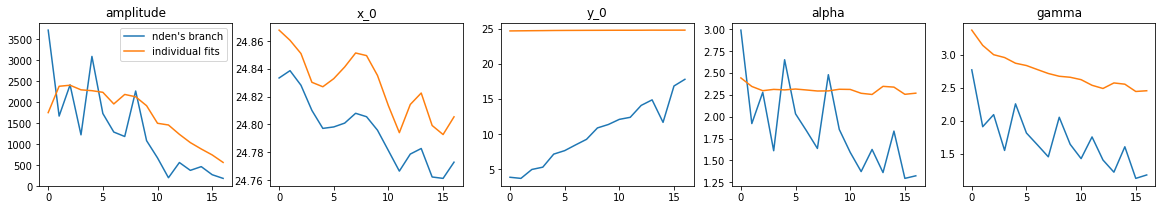

In [18]:
fig, axes = plt.subplots(1, 5, figsize=(5*4, 3))
for ax, attr in zip(axes.flat, ('amplitude', 'x_0', 'y_0', 'alpha', 'gamma')):
    ax.plot(getattr(fit, attr), label="nden's branch")
    ax.plot([getattr(f[1], attr) for f in fitres], label='individual fits')
    ax.set_title(attr)

axes.flat[0].legend();
#axes.flat[-1].axis('off');

## Fit all slices - remove background as Compound model does not work

In [19]:
c.mask_ellipse((c.shape[1]/2, c.shape[1]/2), 4, 0, unit_center=None)

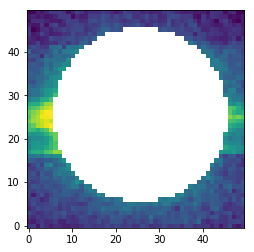

In [20]:
c[0].plot(zscale=True)

In [21]:
bkg = np.array([im.background()[0] for im in c])
c.unmask()

c_bkgsub = c - bkg[:, None, None]

In [22]:
n_models = c.shape[0]
shape = c.shape[1:]
yy, xx = np.mgrid[:shape[0], :shape[1]]
x_0, y_0 = np.array(shape) / 2

fitter = fitting.LevMarLSQFitter()

In [23]:
data = c_bkgsub.data.filled(0)
amplitude = [d.max() for d in data]

In [25]:
data.shape

(17, 50, 50)

In [26]:
x_0, y_0

(25.0, 25.0)

In [27]:
#model = (models.Const2D(amplitude=[0]*n_models, n_models=n_models) + 
#         models.Moffat2D(amplitude=amplitude, x_0=[x_0]*n_models, y_0=[y_0]*n_models, gamma=[3]*n_models, alpha=[2.5]*n_models, n_models=n_models))

model = models.Moffat2D(amplitude=amplitude, x_0=[x_0]*n_models, y_0=[y_0]*n_models, gamma=[3]*n_models, alpha=[2.5]*n_models, n_models=n_models)

fit = fitter(model, xx, yy, data, maxiter=500, estimate_jacobian=True)

/home/simon/dev/astropy/astropy/modeling/functional_models.py:2340: RuntimeWarning: overflow encountered in multiply
  return amplitude * (1 + rr_gg) ** (-alpha)


In [28]:
fit

<Moffat2D(amplitude=[ 3820.48982817,  1511.56632015,  2611.83737438,  1308.5733207 , 3066.38266505,  2762.47521204,  2118.61695753, 44457.70819716, 2420.47148787,  1683.84690849,   721.13992839,   790.02658898, 830.19695328,   510.12561374,   926.18989327,   328.69381368, 242.70026524], x_0=[24.83381391, 24.83938231, 24.82848117, 24.81013738, 24.7974371 , 24.79785479, 24.80042775, 42.14663418, 24.80590784, 24.79573389, 24.78144488, 24.76533693, 24.77703435, 24.78210668, 24.76191661, 24.76104204, 24.77222358], y_0=[   3.82319018,    3.55276196,    4.99264011,    5.34990747,    7.11122462, 8.04352526,    8.87567007, -207.11895477,   10.90507897,   11.66504228, 12.16444255,   13.20752294,   14.44816817,   15.17872614,   11.15896396, 17.08496893,   18.01877236], gamma=[ 2.78021017,  1.81438422,  2.13271461,  1.60865249,  2.2339572 , 2.2226557 ,  2.0186312 , 17.67850764,  2.1006252 ,  1.86293117, 1.52845365,  1.47975001,  1.7270391 ,  1.53499674,  2.09314359, 1.45750404,  1.34616175], alpha

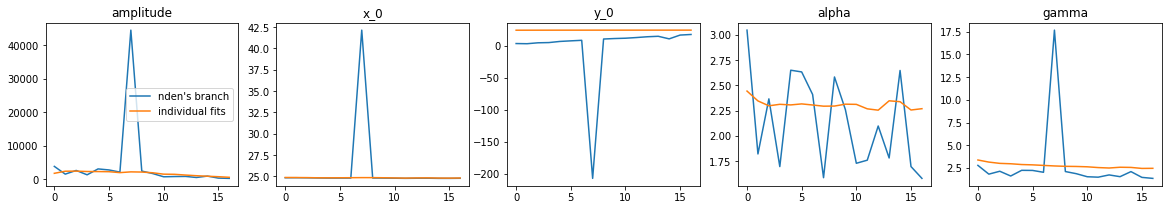

In [29]:
fig, axes = plt.subplots(1, 5, figsize=(5*4, 3))
for ax, attr in zip(axes.flat, ('amplitude', 'x_0', 'y_0', 'alpha', 'gamma')):
    ax.plot(getattr(fit, attr), label="nden's branch")
    ax.plot([getattr(f[1], attr) for f in fitres], label='individual fits')
    ax.set_title(attr)

axes.flat[0].legend();
#axes.flat[-1].axis('off');

## 3D model, now with `scipy.optimize`

From https://gist.github.com/tspriggs/989b57a495ab2831a021fb376e18fabc for another attempt.

### Starts simple, 2D case

In [30]:
from scipy.optimize import least_squares

In [31]:
def moffat(x, y, bkg, amplitude, x_0, y_0, gamma, alpha):
    rr_gg = ((x - x_0) ** 2 + (y - y_0) ** 2) / gamma ** 2
    return bkg + amplitude * (1 + rr_gg) ** (-alpha)

In [32]:
def func(params, x, y, data):
    # params: 
    model = moffat(x, y, *params)
    return np.ravel(model - data)

In [33]:
im = c.mean(axis=0)

In [34]:
data = im.data.filled(0)
res = least_squares(func, (0, data.max(), shape[0]/2, shape[1]/2, 2.5, 3), args=(xx, yy, data))

In [35]:
res.x

array([9.72322450e-01, 1.70152561e+03, 2.48342990e+01, 2.47629226e+01,
       2.76390040e+00, 2.26010337e+00])

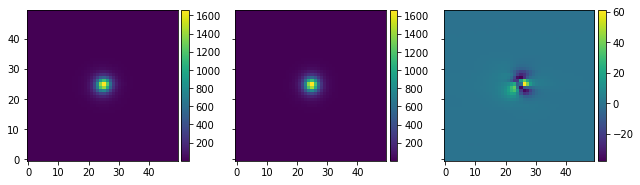

In [36]:
resim = moffat(xx, yy, *res.x)
show_images_grid([data, resim, data - resim]);

### And now 3D, with broadcasting

In [38]:
def moffat(x, y, x_0, y_0, bkg, amplitude, gamma, alpha):
    rr_gg = ((x - x_0) ** 2 + (y - y_0) ** 2) / gamma ** 2
    return bkg + amplitude * (1 + rr_gg) ** (-alpha)

In [102]:
yy, xx = np.mgrid[:c.shape[1], :c.shape[2]]

data = c.data.filled(0)

bkg = np.zeros(n_models)
amplitude = np.array([d.max() for d in data])
gamma = np.zeros(n_models) + 3
alpha = np.zeros(n_models) + 2.5

p0 = np.concatenate([[x_0]*n_models, [y_0]*n_models, bkg, amplitude, gamma, alpha]).tolist()

In [120]:
def func(params, x, y, data):
    x_0, y_0, bkg, amplitude, gamma, alpha = np.array(params).reshape(6, -1)
    model = moffat(xx, yy, x_0[:, None, None], y_0[:, None, None], bkg[:, None, None], 
                   amplitude[:, None, None], gamma[:, None, None], alpha[:, None, None])
    return np.ravel(model - data)

In [109]:
res = least_squares(func, p0, args=(xx, yy, data))

In [121]:
x_0, y_0, bkg, amplitude, gamma, alpha = np.array(res.x).reshape(6, -1)

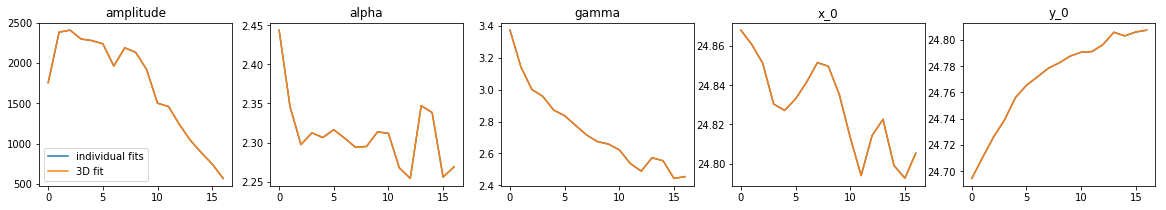

In [113]:
fig, axes = plt.subplots(1, 5, figsize=(5*4, 3))
for ax, attr in zip(axes.flat, ('amplitude', 'alpha', 'gamma', 'x_0', 'y_0')):
    ax.plot([getattr(f[1], attr) for f in fitres], label='individual fits')
    ax.set_title(attr)
for ax, attr in zip(axes.flat, (amplitude, alpha, gamma, x_0, y_0)):
    ax.plot(attr, label='3D fit')
#axes[3].hlines(x_0, 0, 17)
#axes[4].hlines(y_0, 0, 17)

axes.flat[0].legend();
#axes.flat[-1].axis('off');

In [119]:
res

 active_mask: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
        cost: 323435.16341175715
         fun: array([0.30988161, 0.26214352, 0.41188866, ..., 0.42218857, 0.31748722,
       0.34453365])
        grad: array([-6.47960657e-02, -4.84077285e-02, -2.80831293e-02, -1.37173779e-02,
       -3.15968962e-03, -7.44750929e-03, -4.05704037e-02, -1.48264358e-01,
       -1.76831108e-01, -4.15386009e-02,  5.36898079e-02,  1.01356821e-01,
        4.96981585e-02, -4.44686671e-02,  1.48662809e-01,  2.51650472e-01,
        1.17496002e-01, -5.64704951e-02, -5.01200355e-02, -3.00616669e-02,
       